<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the data</a></span></li><li><span><a href="#Nested-Cross-Validation" data-toc-modified-id="Nested-Cross-Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Nested Cross-Validation</a></span></li><li><span><a href="#Encoding-the-Categorical-Variables" data-toc-modified-id="Encoding-the-Categorical-Variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Encoding the Categorical Variables</a></span></li><li><span><a href="#Training-Regression-Models" data-toc-modified-id="Training-Regression-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training Regression Models</a></span></li><li><span><a href="#Feature-Selection-with-Regression-Problem" data-toc-modified-id="Feature-Selection-with-Regression-Problem-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Selection with Regression Problem</a></span></li><li><span><a href="#Final-Model-Tuning" data-toc-modified-id="Final-Model-Tuning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final Model Tuning</a></span></li><li><span><a href="#Performance-of-Final-Regression-Models" data-toc-modified-id="Performance-of-Final-Regression-Models-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Performance of Final Regression Models</a></span></li><li><span><a href="#Classification-Version-of-the-Problem" data-toc-modified-id="Classification-Version-of-the-Problem-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Classification Version of the Problem</a></span></li><li><span><a href="#Training-Classification-Models" data-toc-modified-id="Training-Classification-Models-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Training Classification Models</a></span></li><li><span><a href="#Feature-Selection-with-Classification" data-toc-modified-id="Feature-Selection-with-Classification-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Feature Selection with Classification</a></span></li><li><span><a href="#Final-Model-Tuning" data-toc-modified-id="Final-Model-Tuning-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Final Model Tuning</a></span></li><li><span><a href="#Performance-of-Final-Classification-Model" data-toc-modified-id="Performance-of-Final-Classification-Model-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Performance of Final Classification Model</a></span></li></ul></div>

After having explored the restaurants' characteristics and created some features that capture the historical performance of each restaurant, we now focus on building a predictive model that predicts the performance of a given restaurant during a future inspection. The prediction of future performances can be in terms of estimating the number of low, medium and high violations that can be detected during a future inspection, or in terms of classifying a future inspection as a fail or pass. In other words, our problem can be formulated as a regression or classification problem. While the regression problem provides more granularity to know which restaurants to check first (i.e., those with large high violations number), the data might not be rich enough to predict the number of each type of violation which will make the regression a difficult task with the data we have. In this report, we explore both approaches of the problem. 

The report is divided as follows: we first prepare the features columns and the target variables and split the data into training and test sets where the test set consist of future inspections for the training set. We then explain the cross-validation process that we are going to use in building the predictive models and in selecting the final model. We then start with the regression problem, pre-process the training set, perform feature selection, train some regression models, check their performance in terms of MSE (mean squared error) and R-squared and select a final model. We also repeat the same steps with the classification version of the problem. We finally finish with the insights provided by the models built. 

# Loading the data

We first import the required modules and load the data.

In [273]:
import pandas as pd
import numpy as np
from pingouin import anova
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision
from sklearn.metrics import recall_score as recall, f1_score as f1
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve

In [274]:
data = pd.read_csv('data_to_train.csv')

We extract the columns of feature into X.

In [275]:
X = data.drop(columns=['encounter', 'low', 'medium', 'high'])

Since we are first focusing on the regression problem, our target variables will be the number of low, medium and high violations.

In [276]:
Y = data[['low', 'medium', 'high']]

We now split the data into training and test sets: 80% for training and 20% for testing. Note that the test set corresponds to future inspections for the training set; the data is already sorted according to the inspection date, this is why the test set consists of the last 20% of the data samples.

In [277]:
Xtrain = X.iloc[0:int(len(data)*0.8),:]
Ytrain = Y.iloc[0:int(len(data)*0.8),:]
Xtest = X.iloc[int(len(data)*0.8):,:]
Ytest = Y.iloc[int(len(data)*0.8):,:]

# Nested Cross-Validation

Before we start with the training step, we explain here the cross-validation method that we are going to use to perform feature selection and model selection. Since each instance in our training set corresponds to an inspection on a specific day and holds information about past violations, and since our goal is to predict future performance of restaurants, we are not going to use the regular cross-validation; when we are going to split the training set into sub-training and validations sets, the validation set should consist of subsequent instances for the sub-training set. In particular, we choose the first 60% of the training data as sub-training set and the next 20% of the training data as validation set, then we repeat the same process but now the first 70% of the data represents the sub-training set and the next 20% as validation set and then finally, we use the first 80% of the data as sub-training set and the remaining 20% as validation set. We then compute the average of the performances obtained with each validation set.

We define the function of nested cross-validation as follows. The function takes as input the data features, the target variable, and the metric function that is used in evaluating the performance of the trained model. The function also includes the option of whether we want to scale the data or select from its features. The part of feature selection will be explained in a later section.

In [426]:
def nested_cv_score(x, y, clf, metric_func, scale=False, select=False,
                    score_func=None):
    result = np.zeros((3, len(metric_func)))
    j = 0
    for i in [0.6, 0.7, 0.8]:
        x_train = x.iloc[0:int(len(x)*i), :]
        y_train = y.iloc[0:int(len(y)*i)]
        if(scale == True):
            scaler = StandardScaler()
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
        if(select == True):
            scores = score_func(x_train, y_train, random_state=300)
            x_train = x_train[:, scores != 0]
            print("Number of columns dropped:", sum(scores == 0))

        x_test = x.iloc[int(len(x)*i):int(len(x)*(i+0.2)), ]
        x_test = x_test.values
        if(scale == True):
            x_test = scaler.transform(x_test)
        if(select == True):
            x_test = x_test[:, scores != 0]

        y_test = y.iloc[int(len(x)*i):int(len(x)*(i+0.2))]

        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        for func, ind in zip(metric_func, range(0, len(metric_func))):
            result[j, ind] = func(y_test, ypred)
        j = j+1

    return(np.mean(result, axis=0))

# Encoding the Categorical Variables

The data consist of numerical and categorical columns. The latter include both nominal and ordinal columns. We now encode the nominal categorical columns. 

The columns that we need to encode are the following:

In [282]:
cols_to_encode = [
    'description', 'alcohol', 'good_for_kids', 'good_for_groups',
    'price_range', 'casual', 'classy', 'divey', 'hipster', 'intimate',
    'romantic', 'touristy', 'trendy', 'upscale', 'day_name', 'American',
    'Italian', 'French', 'Mediterranean', 'Spanish', 'European', 'Mexican',
    'Latin American', 'African', 'Caribbean', 'Southern', 'Japanese',
    'Chinese', 'E Asian', 'N/C Asian', 'SE Asian', 'Indian', 'Australian',
    'Pizza', 'Fast/Fried Foods', 'Burgers', 'Dessert', 'Bagels/Pretzels',
    'Gelato', 'Seafood', 'BBQ', 'Steaks', 'Vegetarian', 'Vegan', 'Gluten-Free',
    'Noodles', 'Tacos', 'Sandwiches', 'Sushi', 'Kosher', 'Fruit/Veg', 'Other',
    'Restaurants', 'Mobile', 'Convenience Store', 'Grocery Store', 'Food Shop',
    'Bakeries', 'Coffee Place', 'Other Goods', 'Shopping', 'Services',
    'Entertainment/Event Place', 'Fitness/Sport Place',
    'Teaching/School Place', 'Religious Place', 'Health & Medical Place',
    'Pub/Bars', 'Liquor Manufacturing', 'zip', 'municipal'
]

We are going to try the classic one hot encoding and label encoding as well. 

In [283]:
enc_onehot = ce.OneHotEncoder(cols=cols_to_encode).fit(Xtrain)
Xtrain_onehot = enc_onehot.transform(Xtrain)

In [284]:
enc_ord= ce.OrdinalEncoder(cols=cols_to_encode).fit(Xtrain)
Xtrain_ord = enc_ord.transform(Xtrain)

Note that while most of the categorical columns have at most three unique values, the columns: description, zip and municipal contain more than 3 unique values (description: 21, zip: 88, municipal: 136). On hot encoding scheme increases in this case significantly the total number of features, which we are going to address later through feature elimination.  
The ordinal columns consist of the following columns: 'month', 'day', 'year', 'hour', 'inspect_num' and they all have been assigned integer values, therefore they do not need any encoding.

# Training Regression Models

We now start with training the data, using our defined nested cross-validation function. The models that we are going to use are: linear support vector regressor (used a baseline model) and tree based models: random forest, ada boost, and gradient boosting regressors. We first start with the default parameters for each model, we use the training data encoded with one hot and ordinal encodings, we also start with all features and compare between the models using mean-squared error and we will also look at their R-squared scores. 

In [285]:
models = [LinearSVR(random_state=1), RandomForestRegressor(random_state=1), 
          AdaBoostRegressor(random_state=1), 
          GradientBoostingRegressor(random_state=1)]

In [286]:
import warnings
warnings.filterwarnings("ignore")

for viol in ['low', 'medium', 'high']:
    results = []
    for model in models:
        res = nested_cv_score(Xtrain_onehot, Ytrain[viol], model,
                              [mean_squared_error, r2_score], scale=True)
        results.append(res)
    results = pd.DataFrame(results)
    results.columns = ["Mean Squared Error", "R2 Score"]
    results.rename(index={0: "Linear SVR", 1: "Random Forest Regressor",
                          2: "AdaBoost Regressor",
                          3: "Gradient Boosting Regressor"}, inplace=True)
    if viol == 'low':
        results.index.name = "One Hot Encoding - Low Violation"
    elif viol == 'medium':
        results.index.name = "One Hot Encoding - Medium Violation"
    else:
        results.index.name = "One Hot Encoding - High Violation"
    print(results)

                                  Mean Squared Error  R2 Score
One Hot Encoding - Low Violation                              
Linear SVR                                  8.045280  0.008385
Random Forest Regressor                     5.836208  0.281117
AdaBoost Regressor                          9.030906 -0.112146
Gradient Boosting Regressor                 5.843191  0.280142
                                     Mean Squared Error  R2 Score
One Hot Encoding - Medium Violation                              
Linear SVR                                     1.458459  0.004655
Random Forest Regressor                        1.246249  0.149597
AdaBoost Regressor                             2.503747 -0.708556
Gradient Boosting Regressor                    1.243516  0.151465
                                   Mean Squared Error  R2 Score
One Hot Encoding - High Violation                              
Linear SVR                                   0.807403  0.024286
Random Forest Regressor           

For low and high violations, we see that Gradient boosting regressor and random forest have  better performance (in terms of lower MSE) than the other two models. With high violations, gradient boosting regressor showed the lowest MSE.

In [287]:
import warnings
warnings.filterwarnings("ignore")

for viol in ['low', 'medium', 'high']:
    results = []
    for model in models:
        res = nested_cv_score(Xtrain_ord, Ytrain[viol], model,
                              [mean_squared_error, r2_score], scale=True)
        results.append(res)
    results = pd.DataFrame(results)
    results.columns = ["Mean Squared Error", "R2 Score"]
    results.rename(index={0: "Linear SVR", 1: "Random Forest Regressor",
                          2: "AdaBoost Regressor",
                          3: "Gradient Boosting Regressor"}, inplace=True)
    if viol == 'low':
        results.index.name = "Ordinal Encoding - Low Violation"
    elif viol == 'medium':
        results.index.name = "Ordinal Encoding - Medium Violation"
    else:
        results.index.name = "Ordinal Encoding - High Violation"
    print(results)

                                  Mean Squared Error  R2 Score
Ordinal Encoding - Low Violation                              
Linear SVR                                  7.814561  0.036509
Random Forest Regressor                     5.896790  0.273740
AdaBoost Regressor                          8.236327 -0.015791
Gradient Boosting Regressor                 5.834430  0.281412
                                     Mean Squared Error  R2 Score
Ordinal Encoding - Medium Violation                              
Linear SVR                                     1.369467  0.065405
Random Forest Regressor                        1.259151  0.140800
AdaBoost Regressor                             2.270310 -0.549595
Gradient Boosting Regressor                    1.246730  0.149238
                                   Mean Squared Error  R2 Score
Ordinal Encoding - High Violation                              
Linear SVR                                   0.817994  0.010179
Random Forest Regressor           

With this type of encoding, we notice that gradient boosting classifier always has the lowest MSE for all types of violations. We also notice that gradient boosting with ordinal encoding performed slightly better than with one hot encoding. On the other hand, with medium and high violations, one hot encoding performed better than ordinal encoding.

However, if we look at the score of R-squared, we see that all models are not performing well in terms how well they are fitting the data. We next focus on gradient boosting model and perform feature selection to see if the performance can be boosted.

# Feature Selection with Regression Problem

We now perform feature selection using the filter method. In particular, we compute the mutual information between each feature and the the number of violation for each type. We then drop the features that have 0 mutual information with the target variable. This can help us in removing the redundant features, especially with the one hot encoding scheme that significantly increases the total number of features. We chose the mutual information test over the F-test, because F-test requires some assumptions on the features of the data (normality assumption with same variance), while mutual information do not require that the features hold those assumptions. Moreover, mutual information can detect non-linear relationship between the features and the target variables.

To test whether reducing the number of features can reduce the MSE of the models, we again perform cross-validation, where for each sub-training set we remove the features that have 0 mutual information with the target variable. We compare the obtained results with those obtained when the models considered the total number of features.

We start with the data encoded with one hot encoding; the total number of features here is 499.

In [48]:
Xtrain_onehot.shape[1]

(14648, 499)

In [307]:
for viol in ['low', 'medium', 'high']:
    results = nested_cv_score(Xtrain_onehot, Ytrain[viol],
                              GradientBoostingRegressor(random_state=1),
                          [mean_squared_error, r2_score], scale=True, select=True,
                          score_func=mutual_info_regression)
    
    results = pd.DataFrame(results)
    results = results.T
    results.columns = ["Mean Squared Error", "R2 Score"]
    if viol == 'low':
        results.index.name = "One Hot Encoding - Low Violation"
    elif viol == 'medium':
        results.index.name = "One Hot Encoding - Medium Violation"
    else:
        results.index.name = "One Hot Encoding - High Violation"
    print(results)
    print('\n')

Numbers of columns dropped: 204
Numbers of columns dropped: 200
Numbers of columns dropped: 186
                                  Mean Squared Error  R2 Score
One Hot Encoding - Low Violation                              
0                                           5.850644  0.279305


Numbers of columns dropped: 214
Numbers of columns dropped: 211
Numbers of columns dropped: 211
                                     Mean Squared Error  R2 Score
One Hot Encoding - Medium Violation                              
0                                               1.23661  0.156163


Numbers of columns dropped: 189
Numbers of columns dropped: 184
Numbers of columns dropped: 208
                                   Mean Squared Error  R2 Score
One Hot Encoding - High Violation                              
0                                            0.691962  0.161294




If we compare those results with the ones obtained from the total number of features, we notice that for low and high violations (with one hot encoding), the MSE and R2 scores are close (slightly better with the complete number of features), and with medium violations the MSE and R2 scores are better with less features. Let us now check the other encoding scheme

In [308]:
for viol in ['low', 'medium', 'high']:
    results = nested_cv_score(Xtrain_ord, Ytrain[viol],
                              GradientBoostingRegressor(random_state=1),
                          [mean_squared_error, r2_score], scale=True, select=True,
                          score_func=mutual_info_regression)
    
    results = pd.DataFrame(results)
    results = results.T
    results.columns = ["Mean Squared Error", "R2 Score"]
    if viol == 'low':
        results.index.name = "One Hot Encoding - Low Violation"
    elif viol == 'medium':
        results.index.name = "One Hot Encoding - Medium Violation"
    else:
        results.index.name = "One Hot Encoding - High Violation"
    print(results)
    print('\n')

Numbers of columns dropped: 36
Numbers of columns dropped: 18
Numbers of columns dropped: 26
                                  Mean Squared Error  R2 Score
One Hot Encoding - Low Violation                              
0                                           5.836886  0.281165


Numbers of columns dropped: 35
Numbers of columns dropped: 26
Numbers of columns dropped: 18
                                     Mean Squared Error  R2 Score
One Hot Encoding - Medium Violation                              
0                                              1.247337  0.148848


Numbers of columns dropped: 22
Numbers of columns dropped: 16
Numbers of columns dropped: 18
                                   Mean Squared Error  R2 Score
One Hot Encoding - High Violation                              
0                                            0.699358  0.152308




We notice that with low violations, performing ordinal encoding with feature selection gave the best MSE score. For medium violations, performing one hot encoding with feature selection gave the best MSE score. For high violations, performing one hot encoding without feature selection gave the best MSE score. We next focus on these combinations and fine-tune the models. 

# Final Model Tuning

To check if we can obtain an additional boost in the performance of the gradient boosting model for each type of violation, we now focus on fine tuning some of its parameters. We are also going to use nested cross validation to find the best parameters, but instead of using our defined function for nested cross validation, we are going to divide the process; this is because mutual information takes some time to compute, we will first pre-process our training data for each type of violation and make it ready for model tuning.

We first define two functions that we will use to prepare and pre-process the sub-training and validation sets for each step of the cross validation process.

In [309]:
def prepare(x_train, y_train, x_test, select=False, scale=False, score_func=None):

    if(scale == True):
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

    if(select == True):
        scores = score_func(x_train, y_train)
        x_train = x_train[:, scores != 0]
        x_test = x_test[:, scores != 0]

    return x_train, x_test

In [311]:
def prepare_cross_validation(x, y, select=False):
    res = []
    for i in [0.6, 0.7, 0.8]:
        x_train = x.iloc[0:int(len(x)*i), :]
        y_train = y.iloc[0:int(len(y)*i)]
        x_test = x.iloc[int(len(x)*i):int(len(x)*(i+0.2)), :]
        y_test = y.iloc[int(len(x)*i):int(len(x)*(i+0.2))]
        x_train, x_test = prepare(x_train, y_train, x_test, select=select,
                                  scale=True, score_func=mutual_info_regression)
        res.append(x_train)
        res.append(y_train)
        res.append(x_test)
        res.append(y_test)
    return res

After we have defined the functions that prepare our training data for cross validation, we now use them to prepare the required datasets for each type of violation.

In [312]:
xy_data_low = prepare_cross_validation(Xtrain_ord, Ytrain['low'], select=True)
xy_data_med = prepare_cross_validation(Xtrain_onehot, Ytrain['medium'], select=True)
xy_data_high = prepare_cross_validation(Xtrain_onehot, Ytrain['high'], select=True)

We now define the function that computes that average performances (in terms of MSE) of the given model (clf) on the validation sets. 

In [313]:
def compute_mean_cv(xy_data, clf):
    result = []
    for i in [0, 1, 2]:
        x_train = xy_data[0+4*(i)]
        y_train = xy_data[1+4*(i)]
        x_test = xy_data[2+4*(i)]
        y_test = xy_data[3+4*(i)]
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        result.append(mean_squared_error(y_test, ypred))
    return np.mean(result)

We are now ready to start with fine tuning the models. We will only focus on three parameters of gradient boosting regressor: "n_estimators", "learning_rate" and "max_depth". We start with the first two parameters "n_estimators"  and "learning_rate", because there is a trade-off between these two parameters (n_estimators is the total number of trees and learning rate is the coefficient that shrinks the contribution of each tree).

In [431]:
n_est = [100, 250, 500]
rates = [0.1, 0.05, 0.01]

for viol in ['low', 'med', 'high']:
    min_mse = 1000
    for n in n_est:
        for r in rates:
            model = GradientBoostingRegressor(
                random_state=1, n_estimators=n, learning_rate=r)

            result = compute_mean_cv(
                locals()['xy_data_{}'.format(viol)], model)
            if(result < min_mse):
                min_mse = result
                min_n = n
                min_r = r
    print(viol)
    print(min_mse, min_n, min_r)

low
250 0.05
med
100 0.05
high
250 0.05


The learning rate is 0.05 for all models, and the number of trees is 100 for the model of medium violations and 250 for the models of medium and low violations. We now check the 'max_depth' parameter.

In [315]:
depth = [2, 3, 4, 5, 6, 7]

for viol in ['low', 'med', 'high']:
    min_mse = 1000
    for d in depth:
        n = 250
        if (viol == 'med'):
            n = 100
        model = GradientBoostingRegressor(random_state=1, n_estimators=n,
                                          learning_rate=0.05,
                                          max_depth=d)
        result = compute_mean_cv(locals()['xy_data_{}'.format(viol)], model)
        if(result < min_mse):
            min_mse = result
            min_d = d
    print(viol)
    print(min_mse, min_d)

low
5.790844846584156 4
med
1.2396162199120757 4
high
0.6914830138500928 3


We have 4 as max_depth parameter for the models of low and medium violations, and 3 for the model of high violations.

We next rebuild these models using the whole training set and check their performance on the test set.

# Performance of Final Regression Models

We now test the final models with their chosen parameters on the test set. For this sake, we first fit the chosen models on the whole training set and then check their performance using the test set.

We first prepare and preprocess the test set.

In [316]:
Xtest_onehot = enc_onehot.transform(Xtest)
Xtest_ord = enc_ord.transform(Xtest)

Xtrain_low, Xtest_low = prepare(Xtrain_ord, Ytrain['low'], Xtest_ord,
                                select=True, scale=True,
                                score_func=mutual_info_regression)
Xtrain_med, Xtest_med = prepare(Xtrain_onehot, Ytrain['medium'],
                                Xtest_onehot, select=True, scale=True,
                                score_func=mutual_info_regression)
Xtrain_high, Xtest_high = prepare(Xtrain_onehot, Ytrain['high'],
                                  Xtest_onehot, select=True, scale=True,
                                  score_func=mutual_info_regression)

We then initialize the model for each violation type.

In [317]:
model_low = GradientBoostingRegressor(random_state=1, n_estimators=250,
                                      learning_rate=0.05,
                                      max_depth=4)
model_med = GradientBoostingRegressor(random_state=1, n_estimators=100,
                                      learning_rate=0.05,
                                      max_depth=4)
model_high = GradientBoostingRegressor(random_state=1, n_estimators=250,
                                       learning_rate=0.05,
                                       max_depth=3)

We fit the models using the whole training set and then check their performance on the test set.

In [318]:
model_low.fit(Xtrain_low, Ytrain['low'])
model_med.fit(Xtrain_med, Ytrain['medium'])
model_high.fit(Xtrain_high, Ytrain['high'])

ypred_low = model_low.predict(Xtest_low)
ypred_med = model_med.predict(Xtest_med)
ypred_high = model_high.predict(Xtest_high)

mse_low = mean_squared_error(Ytest['low'], ypred_low)
mse_med = mean_squared_error(Ytest['medium'], ypred_med)
mse_high = mean_squared_error(Ytest['high'], ypred_high)

rs_low = r2_score(Ytest['low'], ypred_low)
rs_med = r2_score(Ytest['medium'], ypred_med)
rs_high = r2_score(Ytest['high'], ypred_high)

In [320]:
print('Low Violations')
print('MSE: {}'.format(mse_low), 'R2: {}'.format(rs_low))
print('Medium Violations')
print('MSE: {}'.format(mse_med), 'R2: {}'.format(rs_med))
print('High Violations')
print('MSE: {}'.format(mse_high), 'R2: {}'.format(rs_high))

Low Violations
MSE: 5.832756214471463 R2: 0.24033434619115324
Medium Violations
MSE: 1.3046813152332875 R2: 0.15682566866445458
High Violations
MSE: 0.7639406850414634 R2: 0.12615197445631632


As expected, the models do not fit well the data, which suggests that regression here is a difficult task with the data we have. Let us know try the second approach of the problem: classification, to see if we can instead detect the set of restaurants that might fail a future inspection (instead of estimating the possible number of violations that can be detected).

# Classification Version of the Problem

We now focus on the classification version of the problem. Since estimating the number of possible violations turned out to be a difficult task for our data, detecting the set of possible restaurants that could fail a future inspection might be an easier task. We now explore the classification approach. By failing an inspection, we assume that at least one high violation or at least 2 medium violations were detected during the inspection. Using this assumption, we create the target variable so that '1' means 'Failed' and '0' means 'Passed'.

In [321]:
Y = pd.Series(len(X)*[0])
Y[np.logical_or((data.medium>1),(data.high>0))]=1

We check the proportion of each class to verify if there is any imbalance between the two classes.

In [322]:
print("Percentage of Passes:", 100*sum(Y==0)/len(Y))
print("Percentage of Failures:", 100*sum(Y==1)/len(Y))

Percentage of Passes: 51.848615586259626
Percentage of Failures: 48.151384413740374


The proportions of the two classes are close to each other, we do not have problems with class imbalances. We now create the training and testing sets for the labeled target variable.

In [323]:
Ytrain = Y.iloc[0:int(len(data)*0.8)]
Ytest = Y.iloc[int(len(data)*0.8):]

We next train some regression problems, perform again feature selection and then fine tune the chosen model.

# Training Classification Models

To compare between the models, we again use our nested cross validation function and the performance is evaluated based on the average accuracy of the models. The models we are going to train are: logistic regression (used as baseline), and tree based classifiers (random fores, ada boost and gradient boosting).

In [326]:
models = [SGDClassifier(loss='log', random_state=1), 
          RandomForestClassifier(random_state=1),
          AdaBoostClassifier(random_state=1), 
          GradientBoostingClassifier(random_state=1)]

We first start with the data processed with one hot encoding.

In [327]:
results=[]
for model in models:
    res = nested_cv_score(Xtrain_onehot, Ytrain, model, [accuracy], scale=True)
    results.append(res)
results = pd.DataFrame(results)
results.columns = ["Accuracy"]
results.rename(index={0: "Logistic Regression", 1: "Random Forest Classifier", 
                      2: "AdaBoost Classifier",
                     3: "Gradient Boosting Classifier"}, inplace=True)
results.index.name = "One Hot Encoding" 
print(results)

                              Accuracy
One Hot Encoding                      
Logistic Regression           0.586462
Random Forest Classifier      0.659954
AdaBoost Classifier           0.658362
Gradient Boosting Classifier  0.673834


We noticed that gradient boosting classifier also performed the best between the models in terms of accuracy. Let us check now with label encoding.

In [357]:
results=[]
for model in models:
    res = nested_cv_score(Xtrain_ord, Ytrain, model, [accuracy], scale=True)
    results.append(res)
results = pd.DataFrame(results)
results.columns = ["Accuracy"]
results.rename(index={0: "Logistic Regression", 1: "Random Forest Classifier", 
                      2: "AdaBoost Classifier",
                      3: "Gradient Boosting Classifier"}, inplace=True)
results.index.name = "Ordinal Encoding" 
print(results)

                              Accuracy
Ordinal Encoding                      
Logistic Regression           0.617292
Random Forest Classifier      0.665529
AdaBoost Classifier           0.662344
Gradient Boosting Classifier  0.674858


With label encoding, we obtained similar accuracy scores. We next focus only on gradient boosting classifier and check if reducing the number of features can enhance the accuracy scores of the model. We check both encoding schemes.

# Feature Selection with Classification

To perform feature selection, we again use the filter method with the score function mutual information.

We start with one hot encoding.

In [365]:
result = nested_cv_score(Xtrain_onehot, Ytrain,
                          GradientBoostingClassifier(random_state=1),
                          [accuracy], scale=True, select=True,
                          score_func=mutual_info_classif)
print("accuracy", result)

Number of columns dropped: 200
Number of columns dropped: 196
Number of columns dropped: 181
accuracy [0.66916951]


The average accuracy is slightly less than what we obtained with one hot encoding using the total number of features (0.674). Let us know check with ordinal encoding.

In [366]:
result = nested_cv_score(Xtrain_ord, Ytrain,
                          GradientBoostingClassifier(random_state=1),
                          [accuracy], scale=True, select=True,
                          score_func=mutual_info_classif)
print("accuracy", result)

Number of columns dropped: 17
Number of columns dropped: 12
Number of columns dropped: 12
accuracy [0.67360637]


The accuracy we obtained here is also close to what we obtained with ordinal encoding using the complete number of features. However, since the accuracy is better with ordinal encoding without feature selection, we are going next to focus on this combination (ordinal encoding without feature selection) to fine-tune the gradient boosting classifier.

# Final Model Tuning

After having chosen the combination of label encoding and gradient boosting classifier with no feature selection, we now focus on fine-tuning some of the parameters of the gradient boosting classifier. The parameters are: "n_estimators", "learning_rate" and "max_depth". We start with the first two parameters.

In [368]:
n_est = [100, 250, 500]
rates = [0.1, 0.05, 0.01]

max_acc = 0
for n in n_est:
    for r in rates:
        model = GradientBoostingClassifier(
            random_state=1, n_estimators=n, learning_rate=r)
        result = nested_cv_score(Xtrain_ord, Ytrain, model,
                          [accuracy], scale=True, select=False)
        if(result > max_acc):
            max_acc = result
            max_n = n
            max_r = r
print(max_acc, max_n, max_r)

[0.67622298] 500 0.05


We obtain 500 for n_estimators and 0.05 for learning_rate. We now fine-tune the parameter "max_depth".

In [369]:
depth = [2,3,4,5,6,7]

max_acc = 0
for d in depth:
    model = GradientBoostingClassifier(random_state=1, n_estimators=max_n, 
                                       learning_rate=max_r, max_depth=d)
    result =  nested_cv_score(Xtrain_ord, Ytrain, model,
                              [accuracy], scale=True, select=False)
    if(result > max_acc):
        max_acc = result
        max_d = d
        
print(max_acc, max_d)

[0.67622298] 3


We obtain 3 for max_depth. We are now ready to train our final model on the whole training set and check its performance on our testing set.

# Performance of Final Classification Model

To test our final model with its chosen parameters on the testing set, we first pre-process  the whole training set and the test set.

In [379]:
Xtest_ord = enc_ord.transform(Xtest)
scaler = StandardScaler()
scaler.fit(Xtrain_ord)
Xtrain_f = scaler.transform(Xtrain_ord)
Xtest_f = scaler.transform(Xtest_ord)

We define the gradient boosting classifier as our final model using the parameters we fine-tuned.

In [380]:
model_f= GradientBoostingClassifier(random_state=1, n_estimators=max_n, 
                                       learning_rate=max_r, max_depth=max_d)

We fit the model using the whole training set and check its performance on the test set, in terms of accuracy.

In [392]:
model_f.fit(Xtrain_f,Ytrain)
ypred = model_f.predict(Xtest_f)        
print("Accuracy:", accuracy(Ytest, ypred))

Accuracy: 0.6764946764946765


The accuracy is 67.65%, which is expected (the score is close to the ones we obtained when we have used cross validation on the training set). Let us look at the feature importances provided by the final model. We plot the features importance of the top 10 features.

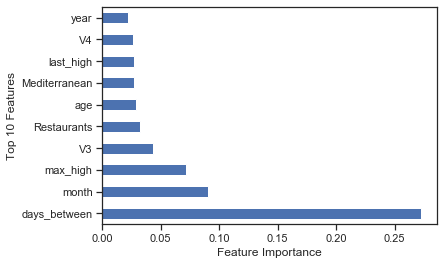

In [433]:
pd.Series(model_f.feature_importances_,
          index=Xtrain_ord.columns).nlargest(10).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Top 10 Features")
plt.show()

We see that the most important feature is "days_between" which specifies the number of days that were between two consecutive inspections. We also notice that the month of the inspection is another important feature, which suggests the presence of some seasonal impacts that affect the restaurant performance. Moreover, past violations in terms of maximum number of high violations so far detected and the last number of high violations detected at a given restaurant are in the top 10 features, which suggests the importance of historical performance of restaurants. The topics modeled from the reviews (V3 and V4) also contributed to the performance of the final model. The feature "Restaurants" specifies if the inspected place is a restaurant or another type of food facility, this indicator represents also an important feature as we have already noticed from visualizing our data.

To check how the model is performing in predicting the true and negative labels, we plot the confusion matrix and compute the precision and recall scores for each class.

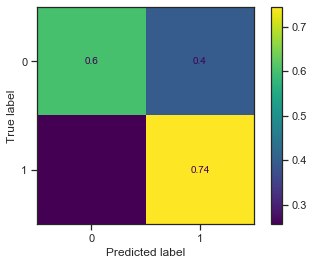

In [393]:
plot_confusion_matrix(model_f, Xtest_f, Ytest, normalize='true')
plt.show()

In [394]:
print("Class: 1 (Fail)")
print("Precision:", precision(Ytest,ypred))
print("Recall",recall(Ytest,ypred))

Class: 1 (Fail)
Precision: 0.6726330664154498
Recall 0.7445255474452555


In [395]:
print("Class: 0 (Pass)")
print("Precision:", precision(Ytest,ypred,pos_label=0))
print("Recall:",recall(Ytest,ypred,pos_label=0))

Class: 0 (Pass)
Precision: 0.6818181818181818
Recall: 0.6017191977077364


While the model is able to recall 74% of the failed inspections (recall for class 1: 74%), the precision for class 1 is 67% which represents the ratio of how many of the predicted failed inspections did actually fail. We have two goals for the inspectors: the first goal is to not let them miss inspecting the restaurants that are making serious violations, the second goal is to help the inspectors prioritize their efforts and be efficient in inspecting first the restaurants that will fail. The first goal can be measured by the precision score, while the second goal can be measured by the recall score. With the current information in our data, we were not able to get an accuracy above 67%; this suggests that if we need to get a better accuracy for our model (more instances of both classes correctly classified, more positive instances that are correctly classified enhance the recall score, more negative instances that are correctly classified enhance the precision score), more historical data need to be collected and more information about each restaurant need to specified. For instance, information related to the workers in the restaurants (number of employees, their level of expertise, their culinary background), or information related to the most times at which each restaurant is busy might all be helpful. Also many of the attributes and categories for many of the restaurants were not specified and were left empty, having them specified might also be helpful. Moreover, when we looked at the reviews we noticed that some restaurants did not have reviews for some periods of time, and we also noticed that even if the restaurant is providing satisfactory services for its customers, it can still make violations. Therefore, encouraging  people to leave more reviews that are not only related to the food served but also to the level of cleanness noticed in the restaurants (restrooms, utensils, quality of food served in terms of freshness) can also be helpful.